# Lab 3: Model Development and Evaluation

In this notebook, we are going to be focusing on building models.

We will compare the performance of a linear regression model, decision tree model and random forest.

Let's get started!

## **If you haven't already, please run through Notebook 1 & 2!**  You need the final ouput df_abridged.csv.

As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Notebook 1 module_1_exploratory_analysis_with_solutions, we merged these data files and created new variables to form the data frame "df_module_1", we exported it as df_module_1.csv. Then in module 2, we engineered several features and removed outliers and exported this to df_module_2_w_outliers.csv. We will use this dataframe now. 


First step is to import the libraries we want to use. Notice there is a new one below - sklearn.ensemble.

Sklearn is a suite of libraries that contain a range of machine learning tools. Today we are using various different sklearn packages. For more information on sklearn, check out their [diagram](http://scikit-learn.org/stable/tutorial/machine_learning_map/) for when and where to use difference machine learning methods.

In [64]:
import xgboost as xgb

C:\Users\g13k8050\Anaconda2\envs\moringa\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from ggplot import *
import time
import re
plt.style.use('ggplot')
%matplotlib inline

# packages for checking assumptions
from scipy import stats as stats

# packages for linear regression and validation 
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# the command below means that the output of multiple commands in a cell will be output at once.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# the command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)


To get more information about a new modules you have imported, run the cell below. A window containing a description of the module will appear! This provides details on the module parameters and attributes and links for further references. Try it out!

In [4]:
RandomForestRegressor?

You can also visit their page on [RandomForestReggresors](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), or visit their helpful [User Guide](http://scikit-learn.org/stable/modules/ensemble.html#forest) for Ensemble Approaches.

Next we import the entire dataset and the kiva data dictionary

In [7]:
# Read in data
data_path = '../../data/'
df = pd.read_csv(data_path+'df_abridged.csv', low_memory=False, encoding = "ISO-8859-1")

In [8]:
# in linux
#df = pd.read_csv(data_path+'df_abridged.csv', low_memory=False)

## Checking Assumptions for our linear regression model

### Normality
In Module 3, we reviewed that normal distribution of variables is an assumption underlying linear regression. Let's look first at our dependent variable, loan_amounts.

We already know our data is skewed by outliers, however before we begin modeling let's quantify the degree to which it is skewed.

[Scipy's stats package](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.skew.html) allows you to conduct a skew test. A normally distributed dataset would return about 0. A skewness value of greater than 0 means there are more loans in the left tail of the distribution. Typically, a skew score of +-5 is deemed acceptable.

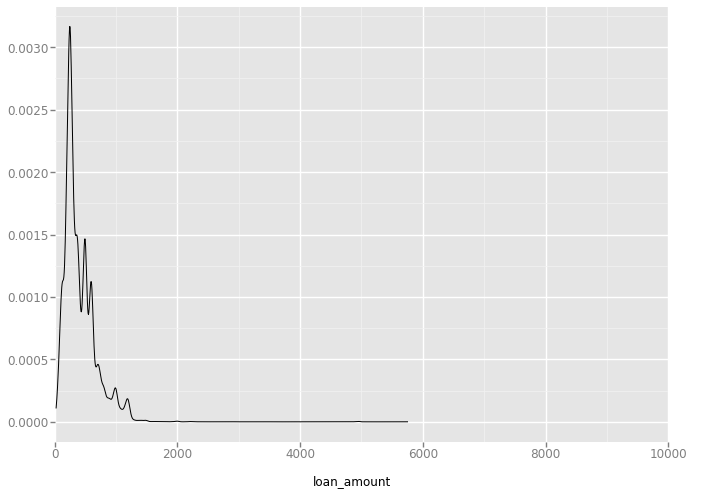

<ggplot: (19614427256)>

In [9]:
ggplot(df[(df['borrower_count'] == 1)], aes(x='loan_amount')) + geom_density() + xlim(0,10000)

In [12]:
print(stats.skew(df[(df['borrower_count'] == 1)].loan_amount, axis=None))

3.5717306366517163


In [13]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,activity,description.texts.en,funded_amount,funded_date,id,lender_count,loan_amount,location.town,partner_id,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.repayment_term,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,...,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,widowed,kids,elderly,num_tags,married,age,age_int,children_int,age_bucket,location,location_detail,location_str,county,province,province_capital,video,motor,solar,eco_friendly,animals,technology,num_posted,num_expired,mean_loan,mean_expired_loan,time_to_fund,days_to_fund,time_to_expire_datetime,days_to_expire,time_to_dispersal,days_to_dispersal,posted_date_unix,top_partner_id,top_partner
0,0,16,16,16,16,Primary/secondary school costs,"Sally is an ambitious woman from Bomet, a maiz...",150,2017-05-09,1291449,6,150,Bomet,156.0,2017-06-07,2017-05-08,Education,funded,"[{'name': '#Parent'}, {'name': '#Schooling'}]",15000.0,KES,2017-05-28T07:00:00Z,150,lender,13,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,2.536684,NaN,1.0,24.200354,18150.0,...,2017-05-28 07:00:00,1,2017-05-28,2017,5,Female,0,1,0,1,0,NaN,29.558037,0.0,NaN,bomet kenya,"Bomet, Kenya","bomet,",bomet,rift valley,bomet,False,0,0,0,0,0,663,NaN,408.6727,NaN,0 days 02:07:40.000000000,0.0,30 days 00:00:00.000000000,30.0,19 days 08:29:54.000000000,19,1.494191e+09,156.0,Juhudi Kilimo
1,1,21,21,21,21,Celebrations,Naomi is a single mother of 2 children and she...,100,2017-05-08,1291404,4,100,nyeri,386.0,2017-06-07,2017-05-08,Personal Use,funded,"[{'name': '#Animals'}, {'name': '#Parent'}, {'...",10000.0,KES,2017-04-03T07:00:00Z,100,lender,5,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.000000,7.017031,NaN,1.0,21.165398,1948.0,...,2017-04-03 07:00:00,1,2017-04-03,2017,5,Female,0,1,0,2,0,NaN,29.558037,2.0,NaN,nyeri kenya,"Nyeri, Kenya","nyeri,",nyeri,central,nyeri,False,0,0,0,1,0,663,NaN,408.6727,NaN,0 days 00:51:40.000000000,0.0,30 days 00:00:00.000000000,30.0,-36 days +08:49:55.000000000,-36,1.494191e+09,1.0,other
2,2,26,26,26,26,Primary/secondary school costs,"Sally is an ambitious woman from a lush, maize...",150,2017-05-08,1291369,6,150,litein,156.0,2017-06-07,2017-05-08,Education,funded,"[{'name': '#Parent'}, {'name': '#Schooling'}]",15000.0,KES,2017-04-28T07:00:00Z,150,lender,14,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,2.536684,NaN,1.0,24.200354,18150.0,...,2017-04-28 07:00:00,1,2017-04-28,2017,5,Female,0,1,0,1,0,NaN,29.558037,0.0,NaN,litein kenya,"Litein, Kericho, Kenya","litein, kericho,",kericho,rift valley,kericho,False,0,0,0,0,0,663,NaN,408.6727,NaN,0 days 01:08:28.000000000,0.0,30 days 00:00:00.000000000,30.0,-11 days +09:59:54.000000000,-11,1.494191e+09,156.0,Juhudi Kilimo
3,3,47,47,47,47,Home Energy,Hello Kiva Community! <br /><br />Meet Margare...,150,2017-05-08,1291075,2,150,Limuru,156.0,2017-06-07,2017-05-08,Personal Use,funded,"[{'name': '#Eco-friendly'}, {'name': '#Technol...",12990.0,KES,2017-04-28T07:00:00Z,150,lender,8,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,2.536684,NaN,1.0,24.200354,18150.0,...,2017-04-28 07:00:00,1,2017-04-28,2017,5,Female,0,1,0,1,1,NaN,29.558037,0.0,NaN,limuru kenya,"Limuru, Kiambu, Kenya","limuru, kiambu,",kiambu,central,kiambu,False,0,0,1,0,1,663,NaN,408.6727,NaN,0 days 03:19:07.000000000,0.0,30 days 00:00:00.0000000

This confirms our suspicion that the data is skewed to the left. However, the degree to which it is skewed is not troubling. +-5 is fairly reasonable. In the cell below we describe a way to address this if you face a dataset with more severely skewed data.

## Additional context on how to deal with skewed data:


One potential solution is to **log transform** your data. For a quick review of logarithms, look [here](https://www.mathsisfun.com/algebra/logarithms.html). 

Note that when we log transform data, we change our interpretation of the final regression output. Previously we had a simple linear equation... 

    y = mx + b

This could be interpreted as, with every unit increase in x, we get a m increase in outcome feature y. Now we have a log equation: 

    log(y) = mx + b
    
This is less intuitive, as we have to solve for y. When we solve for y through exponentiation, we get the following equation: 

    y = 10^(mx + b)
    y = 10^(mx) * 10^(b)

The default base for log is 10. The takeaway here is that the impact x would have on y is much larger than linear - it is **exponentiated**. We will return to this interpretation in the discussion of the linear regression model. Let's try log transforming our loan_amount variable. 

### Check for multicollinearity

Numpy's Corrcoef function returns a matrix of Pearson correlation coefficients. To recap Module 2's lesson, multicollinearity is a problem when we have highly correlated explanatory features, as this makes it difficult for the model to try to differentitae between each feature's influence on the explanatory feature. Read more about Numpy's Corrcoef [here](https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.corrcoef.html).

Try running different features!

In [14]:
np.corrcoef(df[(df['borrower_count'] == 1)].loan_amount, df[(df['borrower_count'] == 1)].funded_amount)

array([[ 1.        ,  0.99999996],
       [ 0.99999996,  1.        ]])

This tells us that loan amount and funded amount are extremely highly correlated - a vast majority of loans requested get funded! Normally, we would be interested in both loan_amount and funded_amount as an outcome feature, but here we see that it would be redundant to test both. 

It would take a long time for us to test each and every relationship between two sets of variables, so let's create a correlation matrix that lets us visualize every correlation in a dataset using Pandas.

In [15]:
df_corr_tbl = df[['loan_amount','partner_loans_posted', 'posted_month', 'partner_delinquency_rate']]
df_corr_tbl.corr()

,loan_amount,partner_loans_posted,posted_month,partner_delinquency_rate
loan_amount,1.000000,-0.199145,-0.021072,0.018819
partner_loans_posted,-0.199145,1.000000,-0.002168,0.316437
posted_month,-0.021072,-0.002168,1.000000,0.000512
partner_delinquency_rate,0.018819,0.316437,0.000512,1.000000


Of course, not every correlation in this table will be meaningful. A correlation table is useful as it provides a visual shortcut to see what relationships might be problematic for multicollinearity. It appears we have no issues with collinearity.

## Preparing Our Data Set for Modeling

Let's now list the features that we want to use in our model.
Sklearn's can only handle boolean or numeric variables, so we will need to one-hot encode
some of the string variables further on. 

The code below reduces the dataframe to the feature columns we want to include, creates a copy of this df which is the **training array**, pulls out the feature that we are trying to predict and stores this as a separate **training results** array.

In [16]:
# list of features that we think may be interested to include
cols = df[['loan_amount', 'num_tags','days_to_fund',\
           'days_to_expire','posted_date_unix', 'married',\
           'posted_month','activity','age_int','children_int',\
           'sector','tags', 'posted_month','posted_year', 'married', 'kids', 'video',\
           'num_posted','partner_loans_posted','partner_delinquency_rate',\
           'age_int', 'top_partner','gender','province','partner_loans_posted','county']]
# create a copy of the dataframe
rf_trainArr = cols.copy()
rf_trainArr = rf_trainArr.dropna()

One of the features here is tags which includes a range of different tags. Although we created fields for some of this tags in module 2 (eco-friendly, animal and technology'), we going to expand this further in this module. It's is also a good opportunity to introduce you to some additional methods to engineer features.

In [17]:
rf_trainArr['tags'].value_counts().index[:10]

Index(['[]', '[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}]',
       '[{'name': 'user_favorite'}]',
       '[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}, {'name': '#Repeat Borrower'}]',
       '[{'name': '#Parent'}]', '[{'name': '#Woman Owned Biz'}]',
       '[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}, {'name': '#Schooling'}]',
       '[{'name': '#Woman Owned Biz'}, {'name': '#Vegan'}, {'name': '#Parent'}]',
       '[{'name': 'volunteer_pick'}]',
       '[{'name': '#Parent'}, {'name': '#Repeat Borrower'}]'],
      dtype='object')

Lets create individual features for tags that we think may be interesting and hot code the reponse. This means that value of that features = 1 if the tag was present and 0 if the tag was not present.

In [18]:
tag_vals = ["#Woman Owned Biz", "#Parent", "user_favorite", "#Repeat Borrower", "#Schooling", "volunteer_pick", "#Vegan", "volunteer_like","#Animals", "#Eco-friendly", "#Technology"]
for tag in tag_vals:
    if tag not in rf_trainArr.columns:
        rf_trainArr['tag_'+str(tag)] = rf_trainArr['tags'].apply(lambda x: 1 if tag in x else 0)


In [19]:
rf_trainArr = rf_trainArr.drop(['tags'], axis=1)

In addition, there are some features which have a large range of possible responses. Instead of using each possible response as a features, we will just take the top 10. So example, lets look at the top activities:

In [20]:
rf_trainArr['activity'].value_counts().index[0:10]

Index(['Farming', 'Dairy', 'Fruits & Vegetables', 'Agriculture', 'Retail',
       'General Store', 'Clothing Sales', 'Poultry', 'Cereals', 'Food Stall'],
      dtype='object')

In [21]:
rf_trainArr.head(2)

,loan_amount,num_tags,days_to_fund,days_to_expire,posted_date_unix,married,posted_month,activity,age_int,children_int,sector,posted_month,posted_year,married,kids,video,num_posted,partner_loans_posted,partner_delinquency_rate,age_int,top_partner,gender,province,partner_loans_posted,county,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology
0,150,1,0.0,30.0,1.494191e+09,0,5,Primary/secondary school costs,29.558037,0.0,Education,5,2017,0,1,False,663,18150.0,2.536684,29.558037,Juhudi Kilimo,Female,rift valley,18150.0,bomet,0,1,0,0,1,0,0,0,0,0,0
1,100,2,0.0,30.0,1.494191e+09,0,5,Celebrations,29.558037,2.0,Personal Use,5,2017,0,1,False,663,1948.0,7.017031,29.558037,other,Female,central,1948.0,nyeri,0,1,0,0,0,0,0,0,1,0,0


The following code takes the top ten occurences for **activity, partner_id, location.town and sector** and creates hot coded. features for each one

In [22]:
col_vals = rf_trainArr['activity'].value_counts().index[:10]

In [23]:
cols_to_separate = ['activity','sector','county','province','gender', 'top_partner']
for col in cols_to_separate:
    # Find the top ten responses
    col_vals = rf_trainArr[col].value_counts().index[:10]
    for col_val in col_vals:
        # for each response, create a new feature column and assign binary responses: 1 for yes and 0 for no
        if col_val not in rf_trainArr.columns:
            rf_trainArr[col+'_'+str(col_val)] = rf_trainArr[col].apply(lambda x: 1 if x == col_val else 0)
    rf_trainArr = rf_trainArr.drop(col, axis=1)

In [24]:
rf_trainArr.head()

,loan_amount,num_tags,days_to_fund,days_to_expire,posted_date_unix,married,posted_month,age_int,children_int,posted_month,posted_year,married,kids,video,num_posted,partner_loans_posted,partner_delinquency_rate,age_int,partner_loans_posted,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,activity_Farming,activity_Dairy,activity_Fruits & Vegetables,activity_Agriculture,activity_Retail,activity_General Store,activity_Clothing Sales,activity_Poultry,activity_Cereals,activity_Food Stall,sector_Agriculture,sector_Food,sector_Retail,sector_Services,sector_Clothing,sector_Transportation,sector_Personal Use,sector_Education,sector_Construction,sector_Health,county_mombasa,county_nakuru,county_nairobi,county_kwale,county_bungoma,county_kisii,county_trans nzoia,county_kiambu,county_uasin,county_kisumu,province_rift valley,province_coast,province_nyanza,province_western,province_eastern,province_nairobi,province_central,gender_Female,gender_Male,top_partner_other,top_partner_VisionFund Kenya,top_partner_Yehu Microfinance Trust,top_partner_SMEP Microfinance Bank,top_partner_Juhudi Kilimo,top_partner_Faulu Kenya
0,150,1,0.0,30.0,1.494191e+09,0,5,29.558037,0.0,5,2017,0,1,False,663,18150.0,2.536684,29.558037,18150.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,100,2,0.0,30.0,1.494191e+09,0,5,29.558037,2.0,5,2017,0,1,False,663,1948.0,7.017031,29.558037,1948.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0
2,150,1,0.0,30.0,1.494191e+09,0,5,29.558037,0.0,5,2017,0,1,False,663,18150.0,2.536684,29.558037,18150.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,150,1,0.0,30.0,1.494191e+09,1,5,29.558037,0.0,5,2017,1,1,False,663,18150.0,2.536684,29.558037,18150.0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
4,75,1,0.0,30.0,1.494191e+09,1,5,29.558037,0.0,5,2017,1,1,False,663,18150.0,2.536684,29.558037,18150.0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0


Why is it necessary to 

## Linear Regression

Now we have two separate datasets: train_set and test_set. We will run the regression on train_set
using statsmodel's "ols" function since the output is more intuitive. Let's try a simple example to start: 

In [25]:
rf_trainArr.head(1)

,loan_amount,num_tags,days_to_fund,days_to_expire,posted_date_unix,married,posted_month,age_int,children_int,posted_month,posted_year,married,kids,video,num_posted,partner_loans_posted,partner_delinquency_rate,age_int,partner_loans_posted,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,activity_Farming,activity_Dairy,activity_Fruits & Vegetables,activity_Agriculture,activity_Retail,activity_General Store,activity_Clothing Sales,activity_Poultry,activity_Cereals,activity_Food Stall,sector_Agriculture,sector_Food,sector_Retail,sector_Services,sector_Clothing,sector_Transportation,sector_Personal Use,sector_Education,sector_Construction,sector_Health,county_mombasa,county_nakuru,county_nairobi,county_kwale,county_bungoma,county_kisii,county_trans nzoia,county_kiambu,county_uasin,county_kisumu,province_rift valley,province_coast,province_nyanza,province_western,province_eastern,province_nairobi,province_central,gender_Female,gender_Male,top_partner_other,top_partner_VisionFund Kenya,top_partner_Yehu Microfinance Trust,top_partner_SMEP Microfinance Bank,top_partner_Juhudi Kilimo,top_partner_Faulu Kenya
0,150,1,0.0,30.0,1.494191e+09,0,5,29.558037,0.0,5,2017,0,1,False,663,18150.0,2.536684,29.558037,18150.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [28]:
model0 = sm.ols(formula="loan_amount ~ gender_Male", data=rf_trainArr).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     129.5
Date:                Tue, 06 Jun 2017   Prob (F-statistic):           5.87e-30
Time:                        13:49:52   Log-Likelihood:            -2.5422e+05
No. Observations:               34279   AIC:                         5.085e+05
Df Residuals:                   34277   BIC:                         5.085e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     446.8321      2.587    172.736      

This is the typical regression output. It's a lot to digest! Remember that our simple model can be represented as a linear equation, like this: 

    loan_amount = intercept + coef*male

Therefore, these results can be translated as follows: 

    loan_amount = 504.29 + 70.89*male
    
Let's state the results. Regardless of gender the predicted loan amount is 424 dollars. However, if the lender is a man the loan amount increases by 110 dollars. This is consistent with our earlier explanatory analysis. How do we know however, whether this is a significant result?

We have a sufficient amount of confidence in this conclusion because the **p-value** is reported to be 0.000. In technical terms, the p-value is **the probability of getting results as extreme as the ones observed. **

In statistics, we want our results to fall within the 95% confidence interval, or the p-value to be <= 0.05. This means, "[i]f repeated samples were taken and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the population mean. A 95% confidence interval has a 0.95 probability of containing the population mean. 95% of the population distribution is contained in the confidence interval." [Read more here.](http://www.investopedia.com/terms/s/standard-error.asp) The p-value is an indicator of where we fall in the confidence interval. In English, small p-value (<= 0.05) indicates strong evidence that the coefficient is different than 0. 

This is a relatively simplified explanation of p-values. Don't worry if it's not immediately intuitive - [not even professional statisticians can easily explain this concept.](http://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) To get a deeper understanding, we recommend grabbing the nearest textbook on statistics to review! 

Note also that the Adjusted R Squared is extremely low. To recap lessons from Module 2, the Adjusted R Squared is an explanation of how much of the outcome feature can be explained by the model's explanatory features. This low Adj R Squared suggests that the predictive value of male is pretty low - it cannot be used as the single feature to predict loan_amount. 

This result is in line with our understanding of the world - there must be other factors influencing loan_amount. Let's try complicating the model by adding more explanatory features. **But which ones?** Let's switch to scikit learn

## Setting up Test and Training Data Set
The next stage is training and testing the algorithm on predicting the loan amount! To do this we need to create four subsets of data:
- X_train: the features to train the algorithm
- y_train: the true value of target feature associated with the training features - In this case, these are the loan amounts
- X_test: the features to test the algorithm
- y_test: the true value of the target features associated with the testing geatures - again, in this case, these are the loan amounts

To do this we will use the sklearn model selection function **train_test_split**. If you look back to the top of this page, we imported this function at the beginning of the notebook.

The names used below (X_train, X_test, y_train, y_test) are the conventions for training and testing data so best to try and train yourselves to use them.

In [26]:
# create a training array = all the features but not the target and a training test array = the results of the target variable for the training array
rf_trainRes = rf_trainArr['loan_amount']
rf_trainArr = rf_trainArr.drop('loan_amount', axis=1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(rf_trainArr, rf_trainRes, test_size=0.2, random_state=42)

## Linear Regression with Scikit Learn

In [28]:
# Linear Regression

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
model1 = regr.fit(X_train, y_train)

print(model1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


Now we print the coefficients to ensure that the outputs are the same as the ones we've gotten when we ran statsmodel. 

In [29]:
# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [ -9.03467831e-01   1.12623500e+01   3.46166721e+00   8.85628076e-06
  -7.00789383e+00  -1.74019501e+01  -1.49031085e-01  -6.89993134e-01
  -1.74019488e+01  -3.35150570e+02  -7.00789377e+00   4.02376934e+00
  -1.76450212e+02  -6.47912048e-02   2.81350476e-02   1.80575472e+01
  -1.49031361e-01   2.81353214e-02   3.20134632e+01   8.06096373e+00
   1.20302007e+02   5.48308074e+01  -5.57945941e+00   3.13603135e+01
  -1.91406855e+01   3.20809359e+01  -2.94284060e+01   1.04027915e+01
  -1.58451563e+02  -2.59105531e+01   1.23697857e+00   1.57992812e+00
  -9.58393063e+00  -3.98690588e+01  -2.66725119e+01   9.88549357e+00
  -5.71743794e+01   1.70923452e+00  -8.30271170e+00  -4.27245630e+01
  -1.39962922e+02  -1.03006580e+02  -9.02680468e+01  -1.51813122e+02
  -8.09926642e+01  -1.22192332e+02   3.53727642e+01  -1.64337947e+01
   6.22964643e+02   3.10440815e+01  -7.74046311e+00   3.47956954e+00
   8.46866234e+00  -3.08178408e+01  -2.51526205e+01  -1.66183950e+01
  -1.43776129e+01 

With scikit-learn, we're able to generate some exciting new metrics using our test_set that we created earlier on in the code. First, let's take a look at the predicted value of y, and the true y.  

In [30]:
#predicted y: 
predicted_y = regr.predict(X_test)

#Let's calculate the difference! 
y_diff = abs(y_test - predicted_y)
y_diff[:1]

38354    105.498096
Name: loan_amount, dtype: float64

This is interesting, but the absolute value of the difference between predicted and true Y doesn't tell us too much on its own. However, it is used as an input in calculating many statistical measures of fit. Let's take a look: 

[Mean Absolute Error](https://www.kaggle.com/wiki/MeanAbsoluteError)

The mean absolute error is calculated as the mean of the distance between predicted and true Y. We take the absolute value of (predicted Y - true Y) so we capture the concept of distance for each observation. Then we take the mean over all observations to get a sense of the entire model. The closer the final statistic is to 0, the better.

In [31]:
print("Mean absolute error: %.2f"
     % np.mean(y_diff))

Mean absolute error: 191.83


[Root Mean Squared Error](https://www.kaggle.com/wiki/RootMeanSquaredError)

The root mean squared error is calculated as the square root of the mean of the difference between predicted and true Y squared. This is a little more complicated to interpret than the MAE, but a useful indication of fit. Like the MAE, the closer this final statistic is to 0, the better.  

We use both RMSE and MAE in practice. See [this blog post](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d) for a discussion of the difference between the two metrics.

In [32]:
print("Root mean squared error: %.2f"
      % np.sqrt(np.mean((y_diff) ** 2)))

Root mean squared error: 351.44


CK: This statement is not as clear as per the above output. 

Logically, the Root Mean Squared error is the inverse of the R-squared; In other words, it is a measure of how much of our outcome variable is left **unexplained** by the model we generated, whereas the R-squared is a measure of how much our model **explains** the variation. It therefore makes sense that the values we obtain roughly add up to 1 (0.64 RMSE and 0.35 R-squared)

## Finally, we use sci-kit learn scoring of the model. We will compare this with decision tree next.

In [33]:
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
linear_training_score = model1.score(X_train, y_train)
linear_testing_score = model1.score(X_test, y_test)
print("Train score: " + str(linear_training_score))
print("Test score: " + str(linear_testing_score))

Train score: 0.324209862796
Test score: 0.32273434354


## We can plot how well we did at predicting!

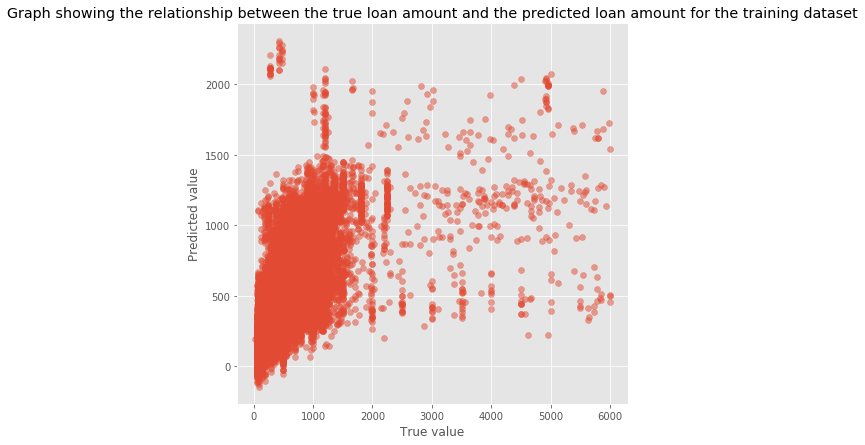

In [34]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
linear_y_predicted_train = model1.predict(X_train)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_train, linear_y_predicted_train, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("Graph showing the relationship between the true loan amount and the predicted loan amount for the training dataset")
plt.show()

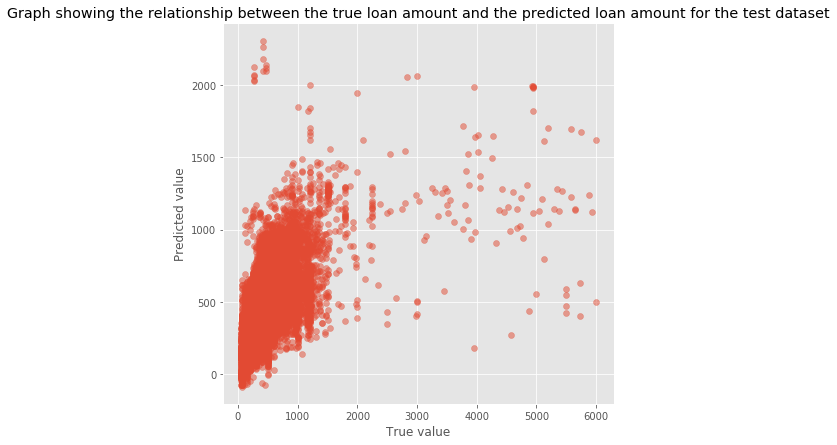

In [35]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
linear_y_predicted_test = model1.predict(X_test)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_test, linear_y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("Graph showing the relationship between the true loan amount and the predicted loan amount for the test dataset")
plt.show()

## Decision Tree and Random Forest


As you learned in the class, decision trees can be used to predict and classify data features. To improve on the simple decision tree, we can use ensemble methods such as Bagging and Random Forest. In an Ensemble approach, the algorithm acts as a group of experts analysing your data and the results is the aggregation of those individual analyses. 

A quick refresher on Bagging
- Grow multiple decisions of random subsets of the data
- All features are considered at every split in the decision tree
- The result is the average prediction of all trees

A quick refresher on the Random Forest theory:
- Random Forest is based on Decision Trees -> many trees = a forest!
- Grows multiple trees on random subsets of the parent dataset
- **At every split, a new random subset of features is chosen**
- This leads to "decorrelated" trees which leads to a large increase in performance!


Now we will compare linear regressions to decision trees and random forest. We will use the same features and will be predicting the same outcome feature loan_amount.

** we will be looking at how we can predict the loan amount using decision trees, bagged decisions trees and the random forest algorithm.**

However, it is worth mentioning that these methods can also be used to classify data, for example some interesting classification questions we could investigate are:
- Can we classify which loans expired and which one got funded?
- Is a loan posted by a male or female?

Feel free to investigate these on your own time! Here is a very simple example of how the RandomForestClassifier works: https://bicorner.com/2015/10/26/random-forest-using-ipython/

One of the advantages of the RandomForest algorithms is that we can pass through a whole range of features, regardless of whether we believe there is a linear relationship between the target (loan amount) and the feature and then find out which features have the highest influence. Remember from the course notes, the RandomForest Algorithms are based on the concept of decision trees where the set of all possible values are split into non-overlapping groups. 

This can be really powerful tool as it requires less initial investigation and analysis than a regression analysis.

Step by Step approach to modeling:

For the following methods used, there is some standard steps used to implement the algorithms. A simple overvew of these steps are:
- **Step 1: Initiate the algorithm** This is where we define the parameters (& hyperparameters of the algorithm) of the algorithm. For example, this is where we would define the maximum depth, the minimum samples in a leaf etc. To learn more about the parameters for each algorithm, either check the module documentation on the internet or run a cell with the algorithm name followed by ? as we did at the beginning of this notebook for the RandomForestRegressor. These resources will also tell you the default values used for each parameter. 
- **Step 2: Train the algorithm** This is where we train the algorithm by fitting it to the X_train and y_train datasets. 
- **Step 3: Evaluating the algorithm** This is where we evaluate the predictive power of the algorithm by comparing the predictive loan amount values to the true values. We can do this for the training and testing dataset.

Let's start with **loan amount** and see if we can predict how much is requested to be funded using the decision trees and ensemble methods! 

### Decision Tree
Before we get into some of the more sophisticated models, let's first try an individual Decision Tree and see how it performs.  After training the model, we will be able to assess it's performance by using sklearns useful method .score, which calculates the r2 value for the data provided.  We will first print out the r2 score for the training data, and then will print out the r2 score for the test data.

In [36]:
from sklearn.tree import DecisionTreeRegressor
# Step 1: Initiating the DecisionTreeRegressor algorithm
decision_regressor = DecisionTreeRegressor(random_state=0)
# Step 2: Training the algorithm using the X_train dataset of features and y_train, the associated target features
decision_regressor.fit(X_train, y_train)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
dt_training_score = decision_regressor.score(X_train, y_train)
dt_testing_score = decision_regressor.score(X_test, y_test)
print("Train score: " + str(dt_training_score))
print("Test score: " + str(dt_testing_score))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

Train score: 0.999421573638
Test score: 0.472329355373


From the scores above (the R^2 of the regression between true and predicted loan amounts), we can see that the decision tree works very well on the training dataset, as expected. However, when applied to the testing dataset, it performs much worse. 

The R^2 number above are pretty telling but it is always nice to visualise how these look in a scattor plot. This allows us to visualise the variation between the predicted loan amount and the true loan amount values. 

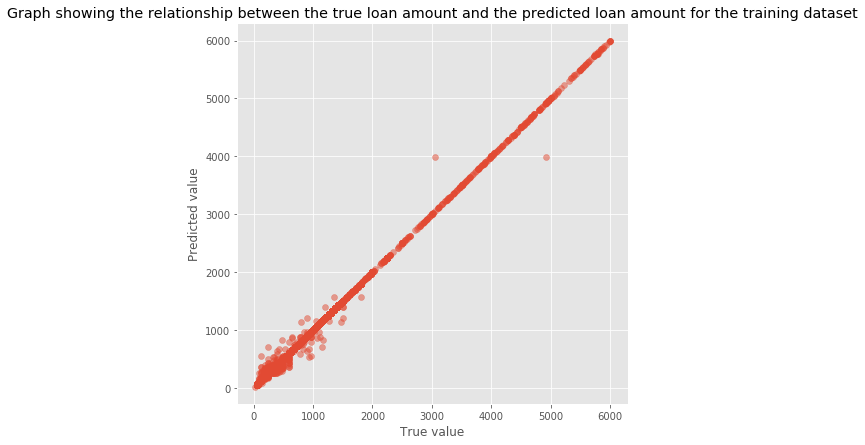

In [37]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
dt_y_predicted_train = decision_regressor.predict(X_train)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_train, dt_y_predicted_train, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("Graph showing the relationship between the true loan amount and the predicted loan amount for the training dataset")
plt.show()

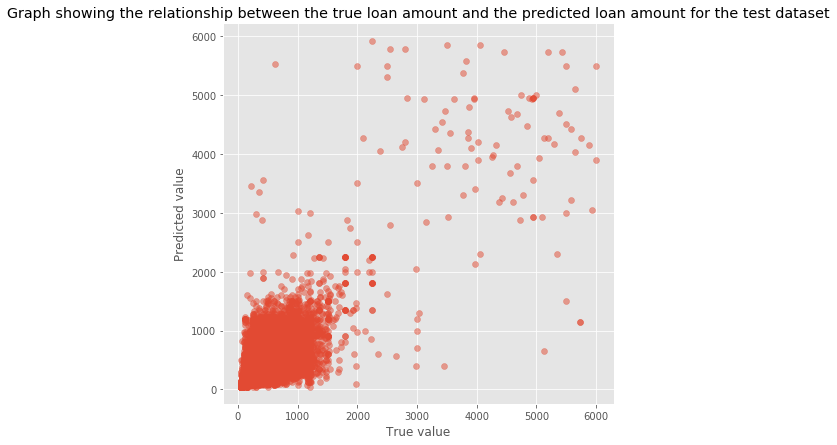

In [38]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
dt_y_predicted_test = decision_regressor.predict(X_test)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_test, dt_y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("Graph showing the relationship between the true loan amount and the predicted loan amount for the test dataset")
plt.show()

The decison tree regressor is near perfect on the training data; however, much worse on the test data.  This is largely due to the likelihood an individual trees  of overfitting to the data. Remember overfitting can occur when the tree goes too deep, the minimum leaf sample if too small or the maximum number number of terminal nodes is too high. We can mitigate the impact of overfitting by tuning and optimising these hyperparameters. However, often it is very time consuming and difficult to find the optimal hyperparameters and therefore we look towards ensemble approaches for an easier, more general solution. 

## Bagging

Another approach to overcome this is to build a collection of trees with sklearn's BaggingRegressor.  A bagging regressor builds some specified number of trees and trains each tree with a random subset of the data and then averages the forecast of each individual tree. 

This is an **Ensemble approach** where we use the results of several random analyses to find an average response. For each tree, there will be a sample of data which was not used to train the algorithm. This means that we can also measure the **out-of-bag** score ( or oob_score). This score calculates the error rate of the predictions on the sample not used while training an individual tree. (Remember a random ~2/3 of data are used to train a given tree).

In [39]:
from sklearn.ensemble import BaggingRegressor
# Step 1: Initiating the bagging regressor algorithm
bagging_regressor = BaggingRegressor(oob_score=True)
# Step 2: Training the bagging regressor algorithm
bagging_regressor.fit(X_train, y_train)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
br_training_score = bagging_regressor.score(X_train, y_train)
br_testing_score = bagging_regressor.score(X_test, y_test)
br_oob_score = bagging_regressor.oob_score_
print("Train score: " + str(br_training_score))
print("Test score: " + str(br_testing_score))
print("Oob score: " + str(br_oob_score))

C:\Users\g13k8050\Anaconda2\envs\moringa\lib\site-packages\sklearn\ensemble\bagging.py:986: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

Train score: 0.937893765154
Test score: 0.69118768946
Oob score: 0.567216122723


The results above show that the train R^2 score has reduced but the test R^2 score has increased. This is a good sign as it means that the algorithm is overfitting the training less and therefore improving its ability to predict the loan amounts on unseen samples. 

When comparing the different regression models, we will be looking at three main outputs:
- Train score = R^2 between the predicted and true values for the training dataset
- Test score = R^2 between the predicted and true values for the test dataset
- Oob_score = the error rate of predicted values for data not used whilst training an individual tree

Therefore, we are defining a function below that prints out these score's us

In [40]:
# Since we will evaluate a few models, let's define a function that prints out the scores we care about
def print_scores(regressor, X_train, y_train, X_test, y_test, oob_score=True):
    print("Train score: " + str(regressor.score(X_train, y_train)))
    print("Test score: " + str(regressor.score(X_test, y_test)))
    print("OOB score: " + str(regressor.oob_score_))

### Changing some model parameters

CK: Parmeter optimization would help inprove in the accuraccy  of the model. 

The default number of trees used in the bagging regressor is 10. This means that the algorithms splits the dataset into 10 different tress, trains each one individually, predicts the result from each one individually and then averages the result. 

Let's see how performance changes when we increase the number of trees from 10 to 100.

In [45]:
# Step 1: Initiating the bagging regressor algorithm
bagging_regressor = BaggingRegressor(n_estimators=100, oob_score=True)
# Step 2: Training the bagging regressor algorithm
bagging_regressor.fit(X_train, y_train)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
print_scores(bagging_regressor, X_train, y_train, X_test, y_test, oob_score=True)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

Train score: 0.955865231939
Test score: 0.718162350759
OOB score: 0.682791158997


Here we see an improvement in all score and in particular the oob_score. This is telling us that splitting the dataset into more tree leads to a more accurate average predicton of the loan_amount. 

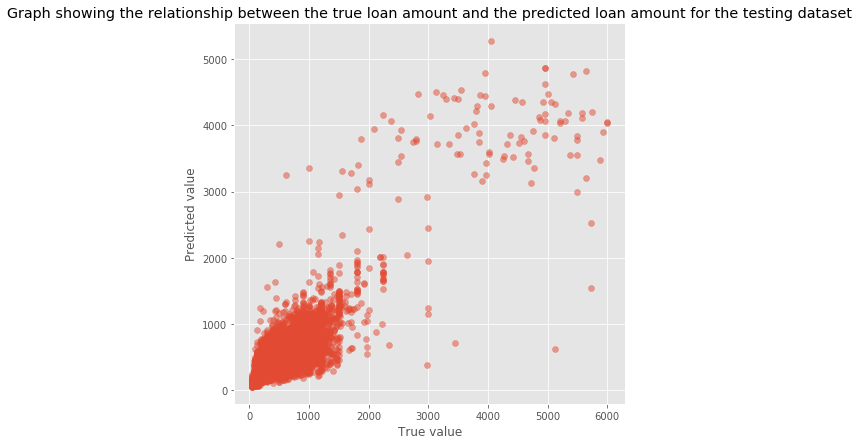

In [42]:
# plotting a grpah of the true values vs the predicted values for the training and test datasets
br_y_predicted_test = bagging_regressor.predict(X_test)
fig = plt.figure(figsize=(7, 7))
plt.scatter(y_test, br_y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("Graph showing the relationship between the true loan amount and the predicted loan amount for the testing dataset")
plt.show()

## Random Forest
We still observe a large discrepancy between the training data and the test data.  This is largely because the decision trees are largely correlated, meaning that ubsets of the same data are probably going to split on the same features and result in very similar predictions.

To de-correlate the trees, we can use a Random Forest Regressor, which only considers a random subsample of the features at each split.

Recall that the difference between the Bagging Regressor and the RandomForest is that in the RandomForest, at each split, a random subset of features is considered. The reducing the chance of correlation between the different trees. 

In [43]:
# Step 1: Initiating the bagging regressor algorithm
rf_regressor = RandomForestRegressor(n_estimators=100, oob_score=True)
# Step 2: Training the bagging regressor algorithm
rf_regressor.fit(X_train,y_train)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
print_scores(rf_regressor, X_train, y_train, X_test, y_test, oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

Train score: 0.956108889331
Test score: 0.719810330662
OOB score: 0.684896425956


WOW! that was unexpected - there is very little change between the bagging regressor and the random forest algorithm. This indicates that the features we are using are already highly uncorrelated.

Mean squared error between the predicted and true loan amounts: 51096 


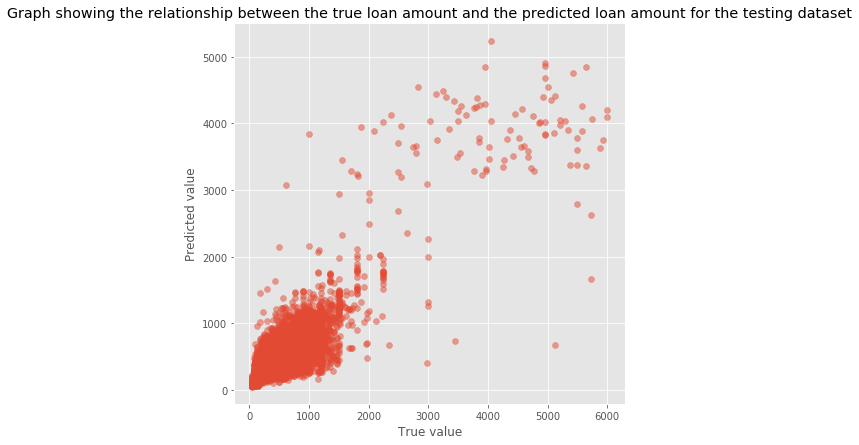

In [46]:
rf_y_predicted_test = rf_regressor.predict(X_test)
print("Mean squared error between the predicted and true loan amounts: %d " % round(mean_squared_error(y_test, rf_y_predicted_test)))

fig = plt.figure(figsize=(7, 7))
plt.scatter(y_test, rf_y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("Graph showing the relationship between the true loan amount and the predicted loan amount for the testing dataset")
plt.show()

Now, let's try to figure out which features are driving our model's predictions.  Although we do not have the coefficients provided by a linear regression, we can analyze what percentage of the overall variance was explained by a given feature.

In [49]:
?rf_regressor

In [55]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]
feature_imp = []
print('Feature Ranking:')
for f in range(len(importances)):
    feature_imp.append([rf_trainArr.columns[indices[f]], importances[indices[f]]])
    print("%d. feature %s (%f)" % (f + 1, rf_trainArr.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature posted_date_unix (0.259850)
2. feature days_to_fund (0.099005)
3. feature partner_loans_posted (0.094633)
4. feature top_partner_other (0.072501)
5. feature partner_loans_posted (0.071754)
6. feature days_to_expire (0.051304)
7. feature num_posted (0.029658)
8. feature sector_Health (0.025510)
9. feature children_int (0.021526)
10. feature sector_Retail (0.018502)
11. feature num_tags (0.017220)
12. feature age_int (0.016391)
13. feature age_int (0.016267)
14. feature partner_delinquency_rate (0.011321)
15. feature posted_year (0.010081)
16. feature posted_month (0.009650)
17. feature posted_month (0.009042)
18. feature tag_#Repeat Borrower (0.007611)
19. feature sector_Education (0.007363)
20. feature tag_user_favorite (0.007054)
21. feature tag_#Eco-friendly (0.006963)
22. feature sector_Agriculture (0.006553)
23. feature top_partner_Juhudi Kilimo (0.005644)
24. feature gender_Male (0.004800)
25. feature gender_Female (0.004705)
26. feature province_rift v

In [60]:
#pd.DataFrame(feature_imp).sort_values(by=1, ascending=False)

Lets visualise the impact of some of the top features:

The borrower count is an intuitive feature; the more borrowers on the loan, the greater the loan will be. Lets look at this relationship again:

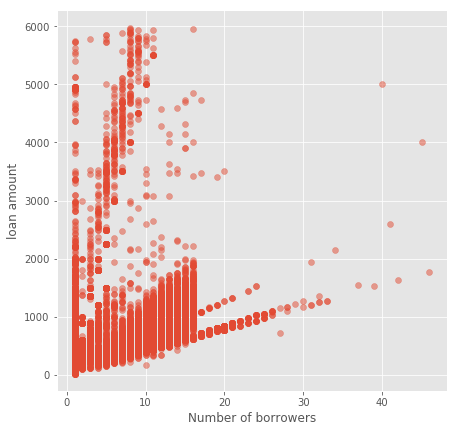

In [99]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(df['borrower_count'], df['loan_amount'], alpha=0.5)
plt.xlabel('Number of borrowers')
plt.ylabel('loan amount')
plt.show()

Now lets look at the next top 2 features, the posted date and the days to fund.

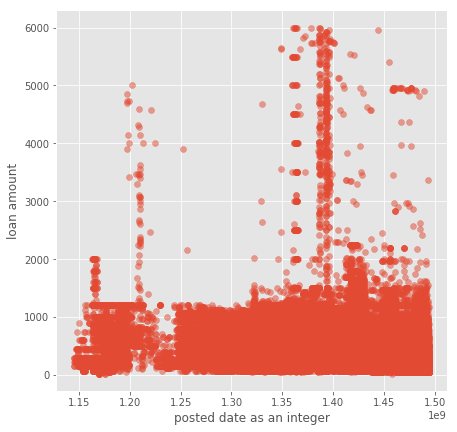

In [56]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(df['posted_date_unix'], df['loan_amount'], alpha=0.5)
plt.xlabel('posted date as an integer')
plt.ylabel('loan amount')
plt.show()

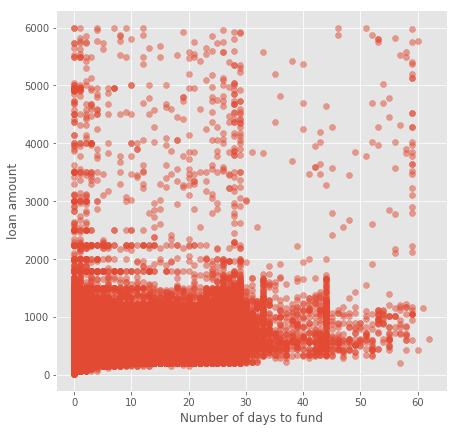

In [57]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(df['days_to_fund'], df['loan_amount'], alpha=0.5)
plt.xlabel('Number of days to fund')
plt.ylabel('loan amount')
plt.show()

What is interesting here is that there is not a very clear relationship between any single feature and the loan_amount. However the aggregat these features together into either the bagged regressor or the random forest algorithm leads to very effective predictions (R^2 ~ 0.74). This is a testament to the predictive power of decisions trees and ensemble methods!

Let's try taking the top 20 features and observe it's impact on performance

In [58]:
relevant_cols = [rf_trainArr.columns[indices[f]] for f in range(20)]
X_train2, X_test2 = X_train[relevant_cols], X_test[relevant_cols]

In [59]:
rf2 = RandomForestRegressor(n_estimators=100, oob_score=True)
rf2.fit(X_train2,y_train)
print_scores(rf2, X_train2, y_train, X_test2, y_test, oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

Train score: 0.944638222597
Test score: 0.696974951404
OOB score: 0.657885885248


The scores haven't changed significantly which means that we can continue just using the top 20 features. This means the algorithms must faster and gives us a clearer idea of which features affect the loan amount

Before we move onto homework, remember to output your final dataframe so you don't have to rerun it.

In [ ]:
df.to_csv(data_path+'df_module_3.csv')

## Homework

Repeat the BaggingRegressor and the RandomForestRegressor method with a new target feature: days_to_fund. Determine the monst important features and discuss which features are intuitive or a surprise and why. 


CK: Lets test this: If both techniques are similar, we can create a function that automates the whole process of training and testinng beginnning with paramter optimization. 

In [61]:
# adding the loan_amount feature back into the rf_trainArr dataset
rf_trainArr['loan_amount'] = rf_trainRes
# The new target feature result is the days_to_fund so pull that out and drop it from the training array
rf_trainRes = rf_trainArr['days_to_fund']
rf_trainArr = rf_trainArr.drop('days_to_fund', axis=1)

In [62]:
# Create X_train, y_train, X_test and y_test where the y value is the days_to_fund feature. 
# Try using test_train_split function imported from sklearn

X_train, X_test, y_train, y_test = train_test_split(rf_trainArr, rf_trainRes, test_size=0.2, random_state=42)

Remember the three basic steps:
- step 1: Initiate the algorithm
- step 2: Fit the algorithm to the training data
- step 3: Evaluate the algorithm performance

## Bagging Regressor

In [63]:
# Step 1: Initiating the bagging regressor algorithm
rf_regressor = RandomForestRegressor(n_estimators=100, oob_score=True)
# Step 2: Training the bagging regressor algorithm
rf_regressor.fit(X_train,y_train)
# Step 3: Calculating the score of the predictive power on the training and testing dataset.
print_scores(rf_regressor, X_train, y_train, X_test, y_test, oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

Train score: 0.95663490853
Test score: 0.68235662781
OOB score: 0.686891771881


In [ ]:
# Use the BaggingRegressor method to predict the days_to_fund

In [ ]:
# Use the RandomForest Regressor method to predict the days_to_fund

In [ ]:
# Find the most important features

## Advanced Homework (optional)

The sklearn RandomForest library also has a classifier method, which rather than predicting a continuous numerical value such as loan amount or days to fund, it attempted to classify data on existing labels, eg: male or female. 

We imported this method at the beginning and you can read more about it here using the following cell or by going the sklearn [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) webpage.

In [148]:
RandomForestClassifier?

Using this module and the original feature gender, see how well we can classify loans by the gender. The procedure for training and testing data is practically the same as the RandomForestRegressor and the score is the mean accuracy of the predictions rather than the R^2 of the regression. 

## Advanced Material: Optimising the algorithm

Up to this point, we have been largely been using the default values for all of the hyper-parameters.  To increase perfromance we should try adjusting these parameters.  Sklearn's GridSearchCV uses cross-validation to assess the performance of each possible permutation of the hyper-parameters that you specify.

In [140]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [100, 300, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [None, 5, 10]
             }
gridrf = RandomForestRegressor()
grid_rf = GridSearchCV(gridrf, parameters)

In [141]:
grid_rf.fit(X_train2, y_train)

KeyboardInterrupt: 

To find out which set of parameters performed best, we can use the .best\_pramas\_ method

In [ ]:
grid_rf.best_params_

Next, let's check out the variation in performance.

In [ ]:
means = grid_rf.cv_results_['mean_test_score']
stds = grid_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))